In [101]:
import os
import pandas as pd
import numpy as np
import talib
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

pd.set_option('display.max_columns', None) 

In [102]:
# データの読み込み
def load_data(file_names):
    dfs = []
    for file_name in file_names:
        df = pd.read_csv(file_name)
        dfs.append(df)
    return dfs

In [103]:
# 特徴量エンジニアリング
def feature_engineering(df, prefix):
    open = df[f'{prefix}_open'].values
    high = df[f'{prefix}_high'].values
    low = df[f'{prefix}_low'].values
    close = df[f'{prefix}_close'].values
    volume = df[f'{prefix}_volume'].values

    # TA-Libを使用して一般的なテクニカル指標を計算
    df[f'{prefix}_RSI'] = talib.RSI(close)
    df[f'{prefix}_MACD'], _, _ = talib.MACD(close)
    df[f'{prefix}_ATR'] = talib.ATR(high, low, close)
    df[f'{prefix}_ADX'] = talib.ADX(high, low, close)
    df[f'{prefix}_SMA'] = talib.SMA(close)
    df[f'{prefix}_EMA'] = talib.EMA(close, timeperiod=30)
    df[f'{prefix}_BB_UPPER'], df[f'{prefix}_BB_MIDDLE'], df[f'{prefix}_BB_LOWER'] = talib.BBANDS(close)
    # df[f'{prefix}_HV_30'] = historical_volatility(close, 30)

    # 欠損値の削除
    df = df.dropna()
    df = df.reset_index(drop=True)

    return df

# 結合のデータフレームに特徴量を追加
def add_features(df):
    df.set_index('15m_timestamp', inplace=True)
    df.index = pd.to_datetime(df.index)
    df['weekday'] = df.index.weekday
    df['month'] = df.index.month
    df['year'] = df.index.year
    
    return df

# def historical_volatility(data, window):
#     data = pd.DataFrame(data)
#     log_returns = np.log(data / data.shift(1))
#     return log_returns.rolling(window=window).std()

In [104]:
# ラベルデータ作成
def create_label(df, prefix, lookahead=1):
    df[f'{prefix}_target'] = (df[f'{prefix}_close'].shift(-lookahead) > df[f'{prefix}_close']).astype(int)
    df = df.dropna()
    return df

In [108]:
# 学習曲線のグラフを表示する関数
def plot_learning_curve(evals_result):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(np.arange(len(evals_result['training']['binary_logloss'])),
            evals_result['training']['binary_logloss'], label='Training')
    ax.plot(np.arange(len(evals_result['valid_1']['binary_logloss'])),
            evals_result['valid_1']['binary_logloss'], label='Validation')
    ax.set_title('Learning Curve')
    ax.set_xlabel('Boosting Round')
    ax.set_ylabel('Binary Logloss')
    ax.legend()
    plt.show()


# 特徴量の重要度を表示する関数
def plot_feature_importance(model, feature_names):
    importance = pd.DataFrame({"Feature": feature_names,
                               "Importance": model.feature_importance()})
    importance.sort_values(by="Importance", ascending=False, inplace=True)
    plt.figure(figsize=(10, 5))
    sns.barplot(x="Importance", y="Feature", data=importance)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

In [113]:
# 学習と評価
def train_and_evaluate(df):
    features = df.drop('15m_target', axis=1)
    labels = df['15m_target']

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }

    verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
    evals_result = {}  # 学習結果を格納するための空の辞書

    model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=[train_data, test_data],
        num_boost_round=10000,  # 最大学習サイクル数。early_stopping使用時は大きな値を入力
        callbacks=[lgb.early_stopping(stopping_rounds=10, 
                verbose=True), # early_stopping用コールバック関数
                lgb.log_evaluation(verbose_eval)], # コマンドライン出力用コールバック関数
        evals_result=evals_result  # 学習結果を格納する辞書
    )

    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))
    
    # 学習曲線のグラフを表示
    plot_learning_curve(evals_result)

    # 特徴量の重要度を表示
    plot_feature_importance(model, features.columns)

    return model

,15m_timestamp,15m_open,15m_high,15m_low,15m_close,15m_volume,15m_RSI,15m_MACD,15m_ATR,15m_ADX,15m_SMA,15m_EMA,15m_BB_UPPER,15m_BB_MIDDLE,15m_BB_LOWER,15m_target,1h_timestamp,1h_open,1h_high,1h_low,1h_close,1h_volume,1h_RSI,1h_MACD,1h_ATR,1h_ADX,1h_SMA,1h_EMA,1h_BB_UPPER,1h_BB_MIDDLE,1h_BB_LOWER,1h_target,4h_timestamp,4h_open,4h_high,4h_low,4h_close,4h_volume,4h_RSI,4h_MACD,4h_ATR,4h_ADX,4h_SMA,4h_EMA,4h_BB_UPPER,4h_BB_MIDDLE,4h_BB_LOWER,4h_target
0,1627774200000,41796.87,41908.72,41714.43,41794.32,0.873083,55.441502,131.711757,172.466386,27.472171,41521.671667,41563.709717,41958.363053,41854.644,41750.924947,0,1.627866e+12,39510.05,39780.11,39238.47,39617.45,3.975709,25.930324,-462.395881,506.951256,29.003859,41345.570333,41132.905505,41204.632022,40067.102,38929.571978,1.0,1.628222e+12,40221.63,41200.00,39900.01,40736.99,21.549914,57.019532,-131.022970,1037.249518,24.843619,39396.676667,39795.819245,41791.413460,40260.346,38729.278540,0.0
1,1627775100000,41794.32,41837.48,41322.13,41447.67,4.987125,43.706032,97.899487,196.958073,26.388406,41523.327000,41556.223284,42082.070853,41759.902,41437.733147,1,1.627870e+12,39617.45,39900.63,39509.96,39774.63,4.329772,29.960880,-491.824376,498.645452,31.307457,41287.737667,41045.274827,40340.326023,39807.496,39274.665977,1.0,1.628237e+12,40736.99,41127.24,40425.00,40524.50,19.129770,55.285221,-48.150814,1013.320267,23.523107,39361.436667,39842.830906,41049.255767,40606.786,40164.316233,1.0
2,1627776000000,41447.67,41537.68,41146.99,41471.68,4.528700,44.581035,72.208056,210.796068,26.165502,41527.116333,41550.768879,42052.901163,41681.908,41310.914837,1,1.627873e+12,39774.63,39917.87,39693.74,39786.72,2.176801,30.275166,-508.311609,479.037205,33.373512,41214.664333,40964.077741,39958.572170,39707.986,39457.399830,0.0,1.628251e+12,40524.50,42150.00,40317.56,42149.99,42.918174,64.244558,146.994958,1071.828819,22.568489,39390.152333,39991.679880,42223.561408,40899.474,39575.386592,1.0
3,1627776900000,41471.68,41646.94,41422.70,41638.83,0.097362,50.365107,64.590462,211.756349,25.276055,41539.077667,41556.450241,41930.851076,41629.874,41328.896924,1,1.627877e+12,39786.72,39852.65,39623.97,39677.97,1.393949,29.013978,-524.111446,461.154548,35.368345,41141.875000,40881.103048,39879.127823,39673.364,39467.600177,1.0,1.628266e+12,42149.99,43367.66,41879.12,42904.00,33.835406,67.497790,358.360734,1101.593903,22.747542,39445.473333,40179.571501,43381.314174,41307.422,39233.529826,0.0
4,1627777800000,41638.83,41697.96,41549.33,41686.15,0.150340,51.895777,61.661002,207.247324,24.145421,41550.248667,41564.817968,41870.121373,41607.730,41345.338627,1,1.627880e+12,39677.97,39822.36,39601.00,39722.28,0.662360,30.288234,-526.982754,444.026366,37.246785,41084.362000,40806.340271,39841.146145,39715.810,39590.473855,1.0,1.628280e+12,42904.00,42961.63,42392.49,42831.88,18.851379,66.871069,514.123656,1063.561482,22.913806,39544.833333,40350.688178,43860.950841,41829.472,39797.993159,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,1628643600000,45733.99,45776.15,45607.33,45609.53,0.381589,53.688718,74.458403,219.453481,11.577857,45461.581333,45504.355869,45792.341591,45653.400,45514.458409,1,1.631344e+12,45225.12,45243.80,44758.39,44921.25,20.973849,39.244029,-258.661116,453.347733,40.593691,45626.559667,45532.039217,45445.845259,45175.896,44905.946741,1.0,1.642133e+12,42635.08,42968.48,42596.29,42631.11,138.907750,47.673857,106.248639,752.678343,17.127152,42509.531000,42822.002096,43201.416575,42744.930,42288.443425,0.0
963,1628644500000,45609.53,45890.64,45580.54,45821.40,0.786056,60.165205,87.291942,225.928232,11.994144,45488.503333,45524.810329,45880.486234,45687.680,45494.873766,0,1.631347e+12,44921.25,45136.64,44804.20,45081.52,14.496575,42.785327,-249.067120,444.711467,40.718695,45574.668333,45502.973461,45440.017125,45159.316,44878.614875,1.0,1.642

/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 394, number of negative: 379
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11224
[LightGBM] [Info] Number of data points in the train set: 773, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509702 -> initscore=0.038815
[LightGBM] [Info] Start training from score 0.038815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

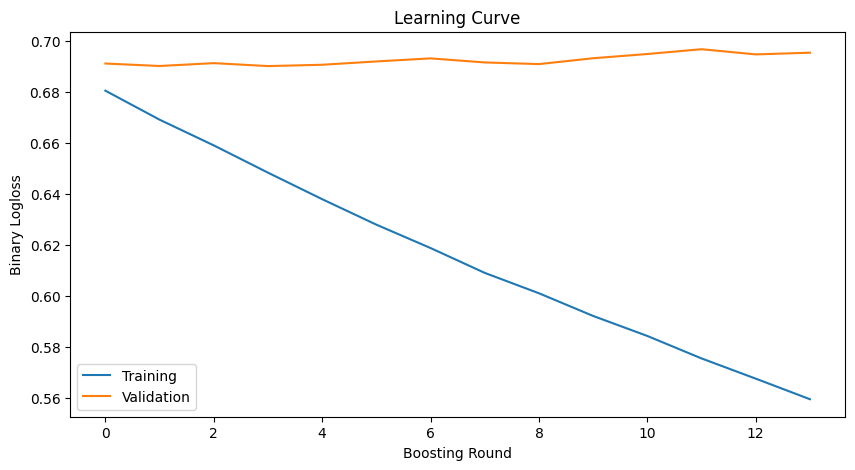

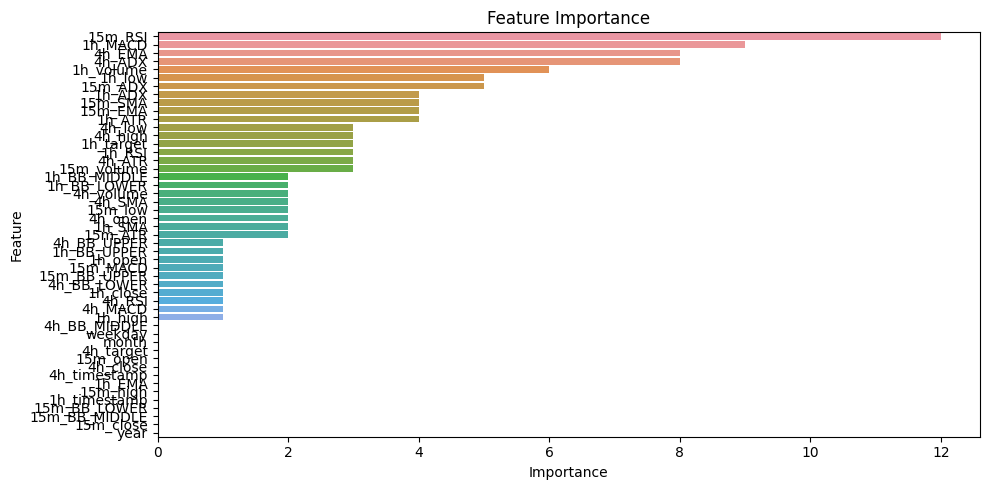

In [114]:
if __name__ == "__main__":
    file_names = [
        "data/BTCUSDT_15m_20210801_20211231.csv", 
        "data/BTCUSDT_1h_20210801_20211231.csv", 
        "data/BTCUSDT_4h_20210801_20211231.csv"]
    dfs = load_data(file_names)

    # 各タイムフレームのデータに対して特徴量エンジニアリングとラベル作成を行う
    processed_dfs = []
    for df in dfs:
        prefix = df.columns[0].split('_')[0]  # カラム名のプレフィックスを取得（例：15m）
        processed_df = feature_engineering(df, prefix)
        processed_df = create_label(processed_df, prefix)
        processed_dfs.append(processed_df)

    # 複数のタイムフレームのデータを結合（インデックスが一致するように注意）
    combined_df = pd.concat(processed_dfs, axis=1).dropna()
    display(combined_df)
    
    # さらに結合後に特徴量を追加する
    combined_df = add_features(combined_df)

    # モデルの学習と評価を行う
    model = train_and_evaluate(combined_df)
 
    # モデルを保存する
    model_path = os.path.join("model", "model.pkl")
    joblib.dump(model, model_path)